In [1]:
import yaml
import platform
import pandas as pd
import glob
from PIL import Image

In [2]:
def check_os():
    os = platform.system()

    if os == 'Darwin':
        return "MacOS"
    elif os == 'Linux':
        return "Linux"
    else:
        return "Unknown OS"
    
operating_system = check_os()


if operating_system == "MacOS":
    root_path = "/Users/johnny/Projects/"
elif operating_system == "Linux":
    root_path = "/home/johnny/Projects/"

In [3]:
file_path = root_path + "datasets/antiuav.v3i/data.yaml"

with open(file_path, 'r') as file:
    yaml_data = yaml.safe_load(file)

yaml_data

{'train': '../train/images',
 'val': '../valid/images',
 'test': '../test/images',
 'nc': 6,
 'names': ['UAV', 'aeroplane', 'boat', 'car', 'person', 'truck'],
 'roboflow': {'workspace': 'ub-xrave',
  'project': 'antiuav-j8hax',
  'version': 3,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/ub-xrave/antiuav-j8hax/dataset/3'}}

In [4]:
train_data = file_path + yaml_data['train']
val_data = file_path + yaml_data['val']

In [5]:
import os
import re

def rename_files(directory, pattern):
    for filename in os.listdir(directory):
        # Use regular expression to find the pattern to remove
        new_filename = re.sub(pattern, '', filename)
        if new_filename != filename:  # Check if the filename actually needs to be changed
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_filename)
            os.rename(old_file, new_file)
            print(f'Renamed: {old_file} to {new_file}')

# Pattern that matches the unwanted part in the filenames
# This will match any '.rf.' followed by any alphanumeric and the file extension
pattern_to_remove = r'\.rf\.[\w-]+'

# Replace these with the actual paths on your system
images_directory = root_path + 'datasets/antiuav.v3i/valid/images/'
labels_directory = root_path + 'datasets/antiuav.v3i/valid/labels/'

# Call the function for both directories
# Make sure to uncomment these lines when running in your local environment
rename_files(images_directory, pattern_to_remove)
rename_files(labels_directory, pattern_to_remove)

# Note: Backup your files before running this script as renaming is irreversible


In [6]:

# Dummy directory paths (you would replace these with your actual directory paths)
images_directory = root_path + 'datasets/antiuav.v3i/valid/images/'
labels_directory = root_path + 'datasets/antiuav.v3i/valid/labels/'

def rename_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith("_jpg.jpg"):
            new_name = filename.replace("_jpg.jpg", ".jpg")
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_name))
            print(f"Renamed {filename} to {new_name}")
        
        if filename.endswith("_jpg.txt"):
            new_name = filename.replace("_jpg.txt", ".txt")
            os.rename(os.path.join(directory, filename), os.path.join(directory, new_name))
            print(f"Renamed {filename} to {new_name}")
            
rename_files(images_directory)
rename_files(labels_directory)           
# Get the list of all image files in the images directory
image_files = glob.glob(images_directory + '*.jpg')

# List to hold the DataFrame rows before concatenation
# List to hold the DataFrame rows before concatenation
df_rows = []

# Function to get image resolution
def get_image_resolution(image_path):
    with Image.open(image_path) as img:
        return img.size

# Read and process each label file and associate it with the corresponding image file
for image_file in image_files:
    # Get the resolution of the image
    image_resolution = get_image_resolution(image_file)

    # Get the base of the file name to match with label files
    base_name = os.path.basename(image_file).replace('.jpg', '')
    
    # Construct the corresponding label file path
    label_file = os.path.join(labels_directory, base_name + '.txt')
    
    # Check if the label file exists
    if os.path.exists(label_file):
        # Read the annotation data from the label file
        with open(label_file, 'r') as file:
            annotation_data = file.readlines()
        
        # Process each annotation in the label file
        for line in annotation_data:
            class_id, x_center, y_center, width, height = line.strip().split()
            # Calculate object size in pixels
            object_width = int(float(width) * image_resolution[0])
            object_height = int(float(height) * image_resolution[1])

            df_rows.append({
                'file_name': base_name + '.jpg',
                'class_id': int(class_id),
                'x_center': float(x_center),
                'y_center': float(y_center),
                'width': float(width),
                'height': float(height),
                'res_width': image_resolution[0],
                'res_height': image_resolution[1],
                'obj_width': object_width,
                'obj_height': object_height,
                'image_path': image_file,
                'label_path': label_file,
            })

# Create a DataFrame from the list of rows
df_annotations = pd.DataFrame(df_rows)

# Display the DataFrame
print(df_annotations.head())


   file_name  class_id  x_center  y_center     width    height  res_width  \
0  00132.jpg         0  0.440625  0.343056  0.322917  0.247222        480   
1  00654.jpg         0  0.526563  0.597222  0.018750  0.014815       1920   
2  02043.jpg         0  0.573438  0.764815  0.030208  0.018519       1920   
3  02043.jpg         3  0.318427  0.984889  0.078839  0.030222       1920   
4  02043.jpg         3  0.285875  0.974361  0.076641  0.051269       1920   

   res_height  obj_width  obj_height  \
0         360        155          89   
1        1080         36          16   
2        1080         58          20   
3        1080        151          32   
4        1080        147          55   

                                          image_path  \
0  /Users/johnny/Projects/datasets/antiuav.v3i/va...   
1  /Users/johnny/Projects/datasets/antiuav.v3i/va...   
2  /Users/johnny/Projects/datasets/antiuav.v3i/va...   
3  /Users/johnny/Projects/datasets/antiuav.v3i/va...   
4  /Users/johnny

In [7]:
# save to csv
df_annotations.to_csv(root_path + 'datasets/antiuav.v3i/valid/annotations.csv', index=False)

In [8]:
full_hd_new_data = df_annotations[(df_annotations['res_width'] == 1920) & (df_annotations['res_height'] == 1080)].copy()
# POST UPDATE
# full_hd_new_data = full_hd_new_data[(full_hd_new_data['resolution_object_width'] >= 10) & (full_hd_new_data['resolution_object_height'] >= 15)]

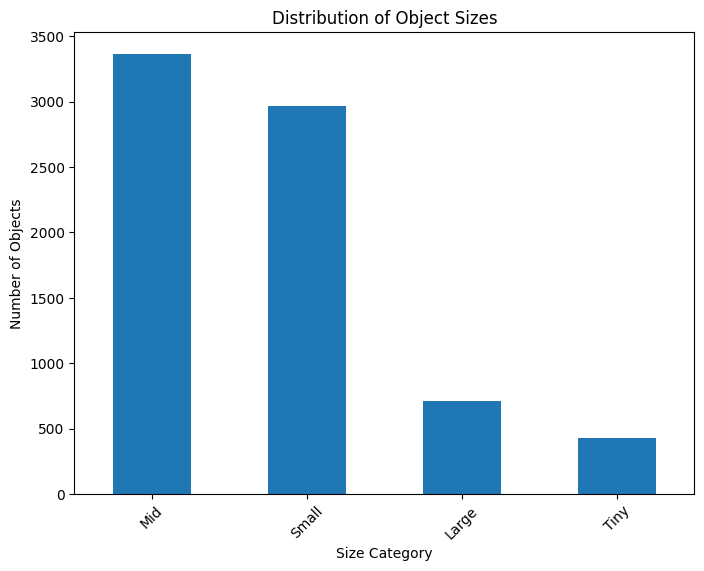

In [9]:
import matplotlib.pyplot as plt
full_hd_new_data['obj_area'] = full_hd_new_data['obj_width'] * full_hd_new_data['obj_height']

def categorize_size(area):
    if area > 96**2:
        return 'Large'
    elif area > 32**2:
        return 'Mid'
    elif area > 16**2:
        return 'Small'
    else:
        return 'Tiny'

# Apply the categorization
full_hd_new_data['size_category'] = full_hd_new_data['obj_area'].apply(categorize_size)

# Plotting the histogram of size categories
plt.figure(figsize=(8, 6))
full_hd_new_data['size_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Object Sizes')
plt.xlabel('Size Category')
plt.ylabel('Number of Objects')
plt.xticks(rotation=45)
plt.show()

In [10]:
import pandas as pd
import os
import shutil
import yaml

csv_path = root_path + 'datasets/antiuav.v3i/valid/annotations.csv'
base_dir = root_path + 'datasets/Client_Validation_Set'

df = pd.read_csv(csv_path)

df = df[(df['res_width'] == 1920) & (df['res_height'] == 1080)].copy()

subfolders = ['train', 'val', 'test']
folders = ['images', 'labels']
for folder in folders:
    for subfolder in subfolders:
        os.makedirs(os.path.join(base_dir, folder, subfolder), exist_ok=True)

for index, row in df.iterrows():
    image_path = row['image_path']
    label_path = row['label_path']
    shutil.copy(image_path, os.path.join(base_dir, 'images', 'val'))
    shutil.copy(label_path, os.path.join(base_dir, 'labels', 'val'))
yaml_data = {
    'path': '../small-fast-detector/inference_tools/Evaluation/datasets/Client_Validation_Set',  # PUT HERE THE PATH
    'train': 'images/train',
    'val': 'images/val',
    'test': '',
    'names': {
        0: 'uav',
        1: 'airplane',
        2: 'boat',
        3: 'car',
        4: 'person',
        5: 'truck'
    }

}
with open(os.path.join(base_dir, 'data.yaml'), 'w') as file:
    yaml.dump(yaml_data, file, default_flow_style=False)

print("Dataset organized and YAML file created.")

Dataset organized and YAML file created.
